In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

F = len('Bartosz')
L = len('Zak')
N = (L + F) * 100

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Excercise 1 - generate data

In [2]:
%%writefile code_1.stan

data {
    int<lower=1> N; //number of samples
}

generated quantities {

    real theta = 0.01;
    array [N] real y;
    for (i in 1:N) {
        /* code */
        if (bernoulli_rng(theta)) {
            y[i] = normal_rng(10,10);
        }
        else {
            y[i] = normal_rng(0,1);
        }
    }
}

Overwriting code_1.stan


In [3]:
%%writefile code_2.stan

data {
    int<lower=1> N; //number of samples
}

generated quantities {
    matrix[N, 3] X;

    {vector [N] zeros = rep_vector(0,N);
    for (j in 1:3) {
        X[:,j]=to_vector(normal_rng(zeros,1));
        /* code */
    }
    }

    vector [3] beta;
    beta = [2, 1, 0.5]';
    
    array [N] real y;
    y = normal_rng (X*beta, 1);
}

Overwriting code_2.stan


In [4]:
model1 = CmdStanModel(stan_file="code_1.stan")
sim1 = model1.sample(data={'N': N}, seed=25042023, iter_sampling=1, iter_warmup=0, chains=1)
df1 = sim1.draws_pd()
df1

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab6/code_1.stan to exe file /root/Data_Analytics/lab6/code_1
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab6/code_1
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,theta,y[1],y[2],y[3],y[4],y[5],y[6],y[7],...,y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999],y[1000]
0,0.0,0.0,0.01,1.16549,0.079893,1.2503,0.824636,-2.04719,-0.325304,0.958276,...,0.71286,-0.506923,-1.14368,-0.031767,-0.130978,-1.36627,-1.30727,0.93335,-0.130641,-0.585383


In [5]:
model2 = CmdStanModel(stan_file="code_2.stan")
sim2 = model2.sample(data={'N': N}, seed=25042023, iter_sampling=1, iter_warmup=0, chains=1)
df2 = sim2.draws_pd()
df2

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab6/code_2.stan to exe file /root/Data_Analytics/lab6/code_2
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab6/code_2
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,"X[1,1]","X[2,1]","X[3,1]","X[4,1]","X[5,1]","X[6,1]","X[7,1]","X[8,1]",...,y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999],y[1000]
0,0.0,0.0,1.16549,-0.27026,-1.73173,-1.22371,-0.314025,0.485908,-0.325304,-0.979494,...,-0.033443,4.77383,3.40312,-2.16397,1.43665,-1.92661,-0.344675,-1.32391,1.06028,-0.874345


#### Excercise 2 - compare normal and student models for data from first file

In [6]:
%%writefile code_3.stan

data {
    int N;
    array [N] real y;
}

parameters {
    real<lower=0> sigma;
    real mu;
}

model {
    target+=-2*log(sigma);
    target+=normal_lpdf(y|mu,sigma);
}

generated quantities {
    vector[N] log_lik;
    array [N] real y_hat;
    for (j in 1:N) {
        log_lik[j] = normal_lpdf(y[j]|mu,sigma);
        y_hat[j] = normal_rng(mu,sigma);
    }
}

Overwriting code_3.stan


In [7]:
%%writefile code_4.stan

data {
    int N;
    array [N] real y;
}

parameters {
    real<lower=0> sigma;
    real mu;
    real<lower=0> nu;
}

model {
    target+=-2*log(sigma);
    target+=gamma_lpdf(nu|2,0.1);
    target+=student_t_lpdf(y|nu,mu,sigma);
}

generated quantities {
    vector[N] log_lik;
    array [N] real y_hat;
    for (j in 1:N) {
        log_lik[j] = student_t_lpdf(y[j]|nu,mu,sigma);
        y_hat[j] = student_t_rng(nu,mu,sigma);
    }
}

Overwriting code_4.stan


In [8]:
model3 = CmdStanModel(stan_file="code_3.stan")
fit1 = model3.sample(data={'N': N, 'y': df1.loc[:, 'y[1]':f'y[{N}]'].values.reshape((N,))},
                     seed=1234)
fit1.draws_pd()

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab6/code_3.stan to exe file /root/Data_Analytics/lab6/code_3
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab6/code_3
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,log_lik[1],...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-1697.58,0.855895,0.869323,2.0,3.0,0.0,1698.56,1.32906,0.070161,-1.54301,...,-0.555351,0.297327,1.096820,-0.061086,2.765880,1.237820,-0.478393,-1.421560,2.643280,0.698696
1,-1696.16,0.913799,0.869323,2.0,3.0,0.0,1698.74,1.34495,-0.007585,-1.59567,...,-0.352771,1.689200,0.025236,-0.321698,-0.134478,0.031786,-0.810873,0.037763,-0.051556,-0.591873
2,-1696.08,0.863255,0.869323,1.0,3.0,0.0,1697.68,1.29476,-0.014066,-1.59224,...,-0.346731,2.274830,0.269082,-2.269720,-0.423386,0.000374,0.369278,0.539787,-1.222620,1.505790
3,-1696.85,0.923784,0.869323,3.0,7.0,0.0,1697.04,1.35988,0.013921,-1.58488,...,1.155910,-1.716040,-0.483192,0.757055,0.292443,1.093610,0.496284,-2.482030,-0.492396,-0.111413
4,-1696.94,0.980939,0.869323,3.0,7.0,0.0,1697.87,1.29154,0.041962,-1.55315,...,-2.487250,-0.580341,-1.202040,-0.062995,2.500760,-0.651686,-0.446286,2.094430,-1.476410,-1.359540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1696.83,0.746400,0.864284,2.0,3.0,0.0,1697.70,1.36002,0.011093,-1.58668,...,0.406080,-0.807366,-0.242989,-0.305609,-2.938450,-0.390649,0.947087,-0.935739,2.154410,-0.076788
3996,-1696.44,0.954524,0.864284,2.0,3.0,0.0,1697.59,1.33778,0.032169,-1.56880,...,-1.485690,0.703562,0.941298,1.364930,0.402721,-1.425800,2.233280,-1.247060,-1.452400,-0.695338
3997,-1696.37,1.000000,0.864284,2.0,3.0,0.0,1696.52,1.33816,0.028697,-1.57108,...,-0.484587,0.326800,1.081950,0.283130,0.117495,-0.474785,-0.390097,-0.456060,-0.331650,1.289400
3998,-1695.75,0.974370,0.864284,1.0,3.0,0.0,1696.62,1.31668,-0.008997,-1.59189,...,-1.672640,-1.067170,0.830328,-0.039890,-2.591570,-1.357920,-0.446848,-3.534290,1.824850,0.925407


In [9]:
model4 = CmdStanModel(stan_file="code_4.stan")
fit2 = model4.sample(data={'N': N, 'y': df1.loc[:, 'y[1]':f'y[{N}]'].values.reshape((N,))},
                     seed=1234)
fit2.draws_pd()

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab6/code_4.stan to exe file /root/Data_Analytics/lab6/code_4
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab6/code_4
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,nu,...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-1512.41,0.960237,0.679942,2.0,7.0,0.0,1513.54,0.927405,-0.044304,5.58270,...,0.123326,0.649215,-0.012750,-0.354586,0.284824,1.235150,0.488891,-0.552415,0.504040,-0.524876
1,-1514.20,0.796054,0.679942,2.0,3.0,0.0,1515.41,0.892506,-0.034502,4.66648,...,0.541553,0.552129,-2.007010,0.614094,0.793510,-1.615630,0.862201,0.462333,0.935619,1.086880
2,-1512.65,0.874372,0.679942,2.0,3.0,0.0,1515.81,0.924127,-0.025512,7.12462,...,-1.550380,-0.895926,-0.093192,0.811662,0.299761,-0.326120,0.478411,-0.383499,0.067157,-1.304830
3,-1514.90,0.939267,0.679942,3.0,7.0,0.0,1515.17,0.960552,-0.115597,6.48744,...,-0.723520,-0.663073,1.579580,0.810143,1.880300,0.621706,1.872220,0.734215,0.910659,0.124459
4,-1513.59,0.996863,0.679942,3.0,7.0,0.0,1516.74,0.927260,-0.006290,5.25405,...,-0.415507,0.465452,-0.393180,1.236110,1.711130,0.268585,-0.492402,1.688570,1.177660,1.452010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1514.36,0.981854,0.564846,3.0,7.0,0.0,1515.02,0.892673,0.013813,6.19659,...,0.549321,-0.620174,0.494653,0.042718,1.324470,1.374860,-0.673900,0.491479,-0.396847,-1.169450
3996,-1512.37,0.984110,0.564846,2.0,7.0,0.0,1515.09,0.930300,-0.022999,6.93824,...,-1.268420,-1.714740,0.614633,0.263965,-0.102950,-0.872510,1.657740,-0.251154,-1.462130,-0.679445
3997,-1513.74,0.832903,0.564846,2.0,5.0,0.0,1515.43,0.890337,-0.085410,6.01258,...,0.277229,-0.934751,0.857089,-0.880702,0.725067,0.244883,-1.380630,2.669010,-0.882342,-0.156851
3998,-1513.90,0.998659,0.564846,3.0,7.0,0.0,1515.03,0.915158,0.015859,5.47416,...,0.467441,0.812382,0.231343,0.622952,0.319036,0.947503,0.421527,1.638280,-1.470190,0.323901


In [10]:
# Create InferenceData objects
inf_data1 = az.from_cmdstanpy(fit1)
inf_data2 = az.from_cmdstanpy(fit2)

In [11]:
inf_data1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [12]:
inf_data2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [13]:
# Compare using loo criteria
model_comp = az.compare({'Normal model': inf_data1, 'Student model': inf_data2}, ic='loo')
model_comp

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Student model,0,-1514.977899,5.569793,0.000000,0.948267,32.48538,0.0000,False,log
Normal model,1,-1709.211089,23.858977,194.233189,0.051733,123.51534,100.3388,True,log


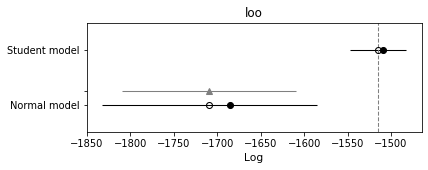

In [14]:
az.plot_compare(model_comp)
plt.title('loo')
plt.show()

In [15]:
# Compare using waic criteria
model_comp = az.compare({'Normal model': inf_data1, 'Student model': inf_data2}, ic='waic')
model_comp

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Student model,0,-1514.863662,5.455556,0.000000,0.948267,32.435083,0.000000,True,log
Normal model,1,-1711.875100,26.522989,197.011438,0.051733,125.528112,102.488455,True,log


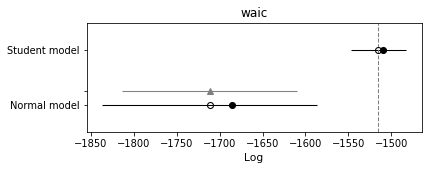

In [16]:
az.plot_compare(model_comp)
plt.title('waic')
plt.show()

#### Excercise 3 - compare models with different numbers of predictors

In [17]:
%%writefile code_5.stan

data {
    int N;
    int K;
    array [N] real y;
    matrix[N,K] X;
}

parameters {
    real<lower=0> sigma;
    vector[K] beta;
}

transformed parameters {
    vector [N] mu;
    mu = X*beta;
}

model {
    y ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    array [N] real y_hat;
    for (j in 1:N) {
        log_lik[j] = normal_lpdf(y[j]|mu[j], sigma);
        y_hat[j] = normal_rng(mu[j],sigma);
    }
}

Overwriting code_5.stan


In [18]:
model5 = CmdStanModel(stan_file='code_5.stan')
pred1 = model5.sample(data={'N': N, 'K':1, 'X': df2.loc[:, 'X[1,1]':f'X[{N},1]'].values.reshape((N,1)), 'y': df1.loc[:, 'y[1]':f'y[{N}]'].values.reshape((N,))},
                     seed=1234)
pred1.draws_pd()

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab6/code_5.stan to exe file /root/Data_Analytics/lab6/code_5
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab6/code_5
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,beta[1],mu[1],...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-776.582,0.887678,0.964374,2.0,3.0,0.0,777.150,1.30745,-0.162945,-0.189911,...,0.341649,-2.209110,-1.362640,2.423400,0.252334,1.604900,-1.702360,-2.495130,1.091180,2.172650
1,-775.727,1.000000,0.964374,2.0,3.0,0.0,776.589,1.32529,-0.145072,-0.169080,...,0.717422,-2.973160,-1.259720,-0.719417,-1.425660,-0.010503,-0.583460,-0.426001,3.753150,1.148840
2,-775.352,0.975100,0.964374,2.0,3.0,0.0,776.271,1.33869,-0.030945,-0.036066,...,2.360380,1.530270,-1.565040,1.964730,-1.519400,-1.414420,-0.961863,1.039350,-0.236002,-0.537094
3,-774.922,0.881900,0.964374,2.0,3.0,0.0,776.834,1.33797,-0.109307,-0.127397,...,0.193825,0.136253,-0.251879,-1.644980,1.573220,-0.225490,0.582304,-0.388447,-0.971287,-1.696170
4,-775.412,0.834217,0.964374,2.0,3.0,0.0,776.658,1.31174,-0.021945,-0.025576,...,0.476078,2.627420,0.888302,-1.030700,-0.688060,-1.059950,0.979612,-0.455258,-0.068521,-1.281450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-774.668,1.000000,0.863647,2.0,3.0,0.0,775.232,1.31945,-0.108578,-0.126546,...,1.319040,0.965233,-0.202248,-0.173411,1.276930,0.769318,-3.031380,0.383142,0.271642,0.817545
3996,-774.570,0.944628,0.863647,1.0,3.0,0.0,775.232,1.32959,-0.063940,-0.074521,...,-0.582416,-0.671836,-0.468342,1.388710,0.882077,-0.214671,1.024420,1.306270,-1.359230,-1.587130
3997,-776.205,0.843168,0.863647,2.0,3.0,0.0,776.356,1.26811,-0.046566,-0.054272,...,2.175480,1.116520,0.190862,0.300067,0.009199,0.744714,-1.725260,1.609140,-1.755980,1.019580
3998,-774.608,1.000000,0.863647,2.0,3.0,0.0,776.339,1.29972,-0.088947,-0.103667,...,0.190532,-1.727900,-0.703131,-1.512300,-0.051079,0.893397,0.561011,0.762592,-0.241685,0.869693


In [19]:
pred2 = model5.sample(data={'N': N, 'K':2, 'X': df2.loc[:, 'X[1,1]':f'X[{N},2]'].values.reshape((N,2)), 'y': df1.loc[:, 'y[1]':f'y[{N}]'].values.reshape((N,))},
                     seed=1234)
pred2.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,beta[1],beta[2],...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-775.517,1.000000,0.695386,2.0,3.0,0.0,779.025,1.30828,-0.029158,0.054316,...,3.318290,-1.310610,-0.031242,-0.783374,0.244154,-0.296656,-1.639870,-0.751559,-0.768014,1.710340
1,-775.729,0.977042,0.695386,2.0,3.0,0.0,775.941,1.31259,-0.041097,0.060950,...,1.881550,-0.577382,-2.894560,1.290740,1.054940,-0.242594,0.300889,1.117080,-2.006960,1.283260
2,-776.247,0.939496,0.695386,2.0,7.0,0.0,777.133,1.31778,0.061925,0.041882,...,-1.099860,2.422980,-0.401750,-1.370150,0.658198,-0.586466,-0.027685,-1.598340,0.240274,1.291030
3,-776.781,0.959257,0.695386,3.0,7.0,0.0,777.696,1.36358,0.008970,0.019962,...,1.220520,-1.028200,0.354051,0.992176,0.226856,1.127310,-0.343340,1.236290,-1.020760,1.929980
4,-776.358,0.977198,0.695386,2.0,3.0,0.0,777.524,1.35459,-0.026236,0.032937,...,-0.830936,-0.467663,-1.572010,2.136110,0.009246,0.562299,0.485618,0.393972,-1.499330,-1.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-777.007,0.904842,0.768504,3.0,7.0,0.0,778.965,1.28763,0.031092,0.122103,...,1.808010,-1.315410,-1.276560,0.429055,-1.394260,0.013615,0.906108,-1.739710,0.238585,0.768824
3996,-775.609,0.964233,0.768504,2.0,3.0,0.0,777.781,1.30950,0.042004,0.065694,...,-0.040043,-1.248970,0.504118,0.017635,-0.457916,-0.176360,-0.921239,2.314080,0.489462,2.070810
3997,-775.655,0.994879,0.768504,3.0,7.0,0.0,776.012,1.32714,-0.037103,0.063230,...,2.163660,-0.905521,-1.238840,-0.515815,-2.160410,2.512450,0.530358,0.126418,-0.139943,-1.693990
3998,-779.036,0.754324,0.768504,2.0,3.0,0.0,779.424,1.37331,-0.076653,0.016760,...,-1.910160,-0.466453,0.912881,-0.284954,0.477677,-0.980920,-0.655947,0.496510,-1.890580,-0.301342


In [20]:
pred3 = model5.sample(data={'N': N, 'K':3, 'X': df2.loc[:, 'X[1,1]':f'X[{N},3]'].values.reshape((N,3)), 'y': df1.loc[:, 'y[1]':f'y[{N}]'].values.reshape((N,))},
                     seed=1234)
pred3.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,beta[1],beta[2],...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-777.830,0.938826,0.898797,3.0,7.0,0.0,779.344,1.28207,0.020594,-0.002350,...,0.325966,0.254502,-0.569286,-0.799172,-1.057820,-1.793440,0.856501,1.955000,-1.196910,0.716962
1,-778.217,0.979531,0.898797,2.0,3.0,0.0,778.971,1.27660,0.022990,-0.018272,...,-2.135850,-0.820023,0.127532,0.464674,-0.901422,0.202323,0.287918,0.167113,-1.311660,-0.165296
2,-777.165,0.970072,0.898797,2.0,3.0,0.0,778.899,1.35561,-0.032438,0.094332,...,-0.834486,3.067980,0.332677,-1.275200,0.684677,0.908924,-1.186130,0.508779,0.326754,0.583192
3,-778.503,0.866716,0.898797,3.0,7.0,0.0,779.746,1.29368,-0.058835,0.087972,...,0.871359,-1.594290,1.721350,-0.846470,1.011030,-0.658931,2.789170,-0.062786,-0.542985,-1.585970
4,-778.423,0.731481,0.898797,2.0,3.0,0.0,782.882,1.27110,0.020687,0.031075,...,-1.078950,-1.057460,-1.230710,1.331600,-1.190960,-0.478349,-1.706150,-0.389049,0.132253,-1.789020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-778.550,0.930105,0.889448,2.0,3.0,0.0,780.577,1.27946,-0.030092,0.091091,...,0.071059,-0.793657,1.606950,1.029710,-0.106165,-1.289750,-0.550385,0.137375,-0.539239,-2.613240
3996,-776.804,0.978986,0.889448,3.0,7.0,0.0,779.393,1.35206,-0.040733,0.040142,...,-0.183050,0.549205,1.344920,-0.766894,-0.617727,-0.660776,-0.049038,-1.500260,2.363790,-0.609948
3997,-779.680,0.770105,0.889448,2.0,3.0,0.0,780.256,1.35410,-0.096221,0.079496,...,0.664061,-1.252280,-0.351778,-0.767547,1.760580,-0.383409,0.292902,-1.056960,-1.174970,-1.169810
3998,-777.499,0.960008,0.889448,3.0,7.0,0.0,780.138,1.30767,0.043545,0.020060,...,0.788517,-2.445880,1.233080,0.680615,-0.486265,2.470800,0.659335,1.484220,0.685433,-0.265869


In [21]:
inf_data1 = az.from_cmdstanpy(pred1)
inf_data2 = az.from_cmdstanpy(pred2)
inf_data3 = az.from_cmdstanpy(pred3)

In [22]:
inf_data1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [23]:
inf_data2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [24]:
inf_data3

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [25]:
# Compare using loo criteria
model_comp = az.compare({'1 predictor model': inf_data1, '2 predictors model': inf_data2, '3 predictors model': inf_data3}, ic='loo')
model_comp

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated sh

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
1 predictor model,0,-1707.997081,24.741884,0.000000,9.145249e-01,122.831049,0.000000,True,log
2 predictors model,1,-1709.696969,25.634614,1.699888,8.547505e-02,122.389397,2.004379,True,log
3 predictors model,2,-1711.542577,27.167789,3.545496,3.108624e-15,124.072052,2.393529,True,log


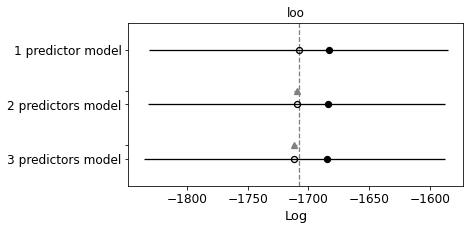

In [26]:
az.plot_compare(model_comp)
plt.title('loo')
plt.show()

In [27]:
# Compare using waic criteria
model_comp = az.compare({'1 predictor model': inf_data1, '2 predictors model': inf_data2, '3 predictors model': inf_data3}, ic='waic')
model_comp

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
1 predictor model,0,-1710.765482,27.510285,0.000000,7.291358e-01,124.927252,0.000000,True,log
2 predictors model,1,-1711.801723,27.739368,1.036241,2.708642e-01,123.997587,2.223537,True,log
3 predictors model,2,-1713.830388,29.455599,3.064906,1.554312e-15,125.837837,2.186198,True,log


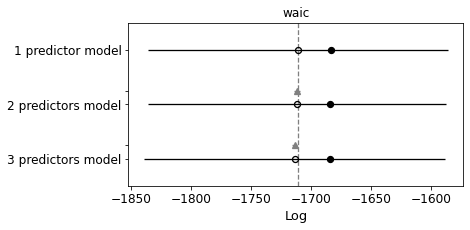

In [28]:
az.plot_compare(model_comp)
plt.title('waic')
plt.show()